In [2]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [3]:
# Load splits

with open('../../Work/Explainer/Splits/EmoidNbackWrat10FoldCV.pkl', 'rb') as f:
    splits = pickle.load(f)

print('Finished')

Finished


In [4]:
import numpy as np

print(len(np.concatenate([splits[0][0],splits[0][1]])))

def getTrainTestIdcs(splits, splitId, makeTorch=True):
    lookup = dict()
    allSplit0Ids = np.concatenate([splits[0][0],splits[0][1]])
    for i in range(620):
        lookup[allSplit0Ids[i]] = i
    trainIdcs = []
    testIdcs = []
    for key in splits[splitId][0]:
        trainIdcs.append(lookup[key])
    for key in splits[splitId][1]:
        testIdcs.append(lookup[key])
    trainIdcs = np.array(trainIdcs)
    testIdcs = np.array(testIdcs)
    if makeTorch:
        trainIdcs = torch.from_numpy(trainIdcs).cuda()
        testIdcs = torch.from_numpy(testIdcs).cuda()
    return trainIdcs, testIdcs

a,b = getTrainTestIdcs(splits, 4, False)
print(a.shape)
print(b.shape)

620
(558,)
(62,)


In [5]:
p_nback = np.zeros([620,264,264])
p_emoid = np.zeros([620,264,264])
age_class = np.zeros([620])
ages = np.zeros([620])
sexes = np.zeros([620],dtype='long')

split0Ids = np.concatenate([splits[0][0],splits[0][1]])

for i in np.arange(620):
    subId = split0Ids[i]
    p_nback[i] = np.corrcoef(meta[subId]['nbackData'])
    p_emoid[i] = np.corrcoef(meta[subId]['emoidData'])
    sex = meta[subId]['meta']['Gender']
    if sex == 'M':
        sexes[i] = 0
    elif sex == 'F':
        sexes[i] = 1
    else:
        raise Exception(f'bad sex {sex} for subject {subId}')
    age = int(meta[subId]['meta']['AgeInMonths'])/12
    if age < 8:
        raise Exception(f'bad age {age} for subject {subId}')
    elif age < 12:
        age_class[i] = 0
    elif age < 14:
        age_class[i] = 1
    elif age < 16:
        age_class[i] = 2
    elif age < 18:
        age_class[i] = 3
    elif age < 23:
        age_class[i] = 4
    else:
        raise Exception(f'bad age {age} for subject {subId}')
    ages[i] = age
    if i % 100 == 0:
        print(f'Finished {i}')
        
print(f'Finished train {i}')

Finished 0
Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished train 619


In [6]:
# Convert to torch

import torch

p_nback_t = torch.from_numpy(p_nback).reshape(-1,264*264).float().cuda()
p_emoid_t = torch.from_numpy(p_emoid).reshape(-1,264*264).float().cuda()
sexes_t = torch.from_numpy(sexes).cuda()
ages_t = torch.from_numpy(ages).float().cuda()

feat_t = torch.cat([p_nback_t, p_emoid_t], dim=1)

print(feat_t.shape)
print('Complete')

torch.Size([620, 139392])
Complete


Loaded
torch.Size([100, 139392])
3.016267
Loaded
torch.Size([100, 139392])
2.50064
Loaded
torch.Size([100, 139392])
2.4680572
Loaded
torch.Size([100, 139392])
2.5108583
Loaded
torch.Size([100, 139392])
3.2937727
Loaded
torch.Size([100, 139392])
2.2827952
Loaded
torch.Size([100, 139392])
3.6255972
Loaded
torch.Size([100, 139392])
2.3611357
Loaded
torch.Size([100, 139392])
2.891175
Loaded
torch.Size([100, 139392])
2.6663408


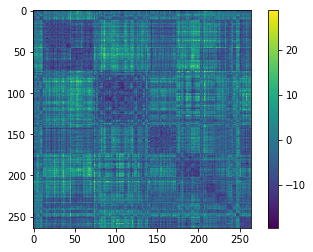

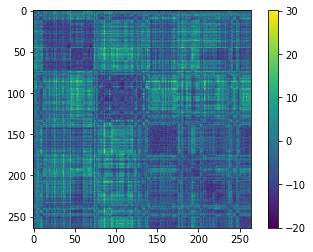

In [17]:
# Load the model

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100).float().cuda()
        self.fc2 = nn.Linear(100,1).float().cuda()
#         self.loss = nn.CrossEntropyLoss()
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ngrads = np.zeros([10,264,264])
egrads = np.zeros([10,264,264])

ageCls = 4

for split in range(10):

    model = MLP()
    model.load_state_dict(torch.load(
        f'../../Work/Explainer/Models/PredictAge5AgeCategories/FullTrain/mlp{split}.pkl'))
    model.eval()

    print('Loaded')

    trainIdcs, testIdcs = getTrainTestIdcs(splits, split, True)

    allIdcs = np.argwhere(age_class == ageCls).flatten()
    idcs = testIdcs
    idcs = np.intersect1d(allIdcs, idcs.detach().cpu().numpy())

    prob = model(feat_t[idcs]).flatten()
    loss = model.loss(prob, ages_t[idcs])
    loss.backward()

    print(model.fc1.weight.grad.shape)
    print(np.mean(torch.abs(ages_t[idcs]-prob).detach().cpu().numpy()))
#     print(np.sum(sexes_t[idcs].detach().cpu().numpy() == np.argmax(prob.detach().cpu().numpy(), axis=1))/len(idcs))

#     plt.imshow(model.fc1.weight[0,:264*264].detach().cpu().numpy().reshape(264,264))
#     plt.colorbar()
#     plt.show()

    dRda = model.fc2.weight.grad@model.fc1.weight
    dRda = dRda.detach().cpu().numpy()
    dRda = np.sum(dRda, axis=0)#*torch.sum(feat_t[idcs], axis=0).detach().cpu().numpy()
    nbackGrad = dRda[0:264*264].reshape(264,264)
    emoidGrad = dRda[264*264:].reshape(264,264)
    
    ngrads[split] = nbackGrad
    egrads[split] = emoidGrad

plt.imshow(np.sum(ngrads[1:], axis=0))
plt.colorbar()
plt.show()

plt.imshow(np.sum(egrads[1:], axis=0))
plt.colorbar()
plt.show()

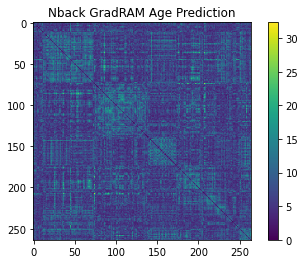

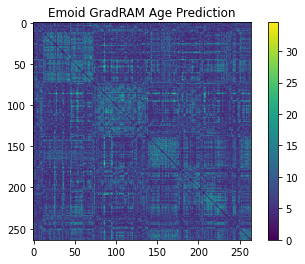

In [20]:
def maskDiag(A):
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise Exception('bad A shape')
    return A*(1-np.eye(A.shape[0]))

ndisp = maskDiag(np.sum(np.abs(ngrads), axis=0))
# ndisp[ndisp < 1e-9] = 0
# ndisp[ndisp > -0.6e-9] = 0
# ndisp[np.all([ndisp < 0.2, ndisp > -0.2])] = 10

edisp = maskDiag(np.sum(np.abs(egrads), axis=0))
# edisp[edisp < 1e-9] = 0
# edisp[edisp > -0.8e-9] = 0

plt.imshow(ndisp)
plt.colorbar()
plt.title('Nback GradRAM Age Prediction')
plt.show()

plt.imshow(edisp)
plt.colorbar()
plt.title('Emoid GradRAM Age Prediction')
plt.show()

In [1]:
import numpy as np

np.any(np.array([1,0,1]))

True